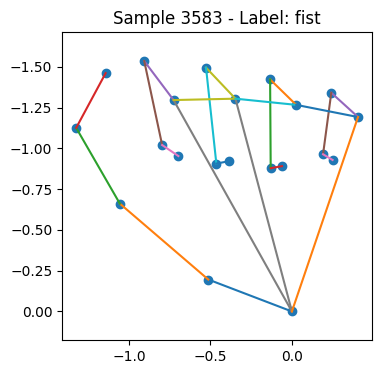

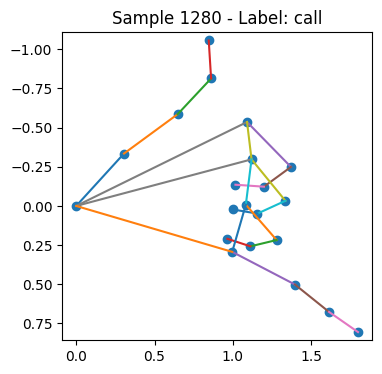

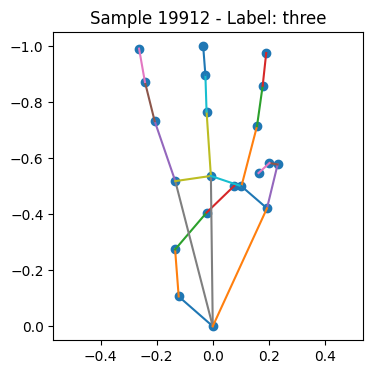

In [ ]:
import sys
sys.path.append("./src")

from preprocessing import load_and_split
from visualization import plot_multiple_samples
import pandas as pd

# Load raw (not split yet for visualization)
df = pd.read_csv(r"C:\Users\Home\Desktop\hand-gesture-classification-ml1\data\hand_landmarks_data.csv")

from preprocessing import normalize_landmarks
df_norm = normalize_landmarks(df)

plot_multiple_samples(df_norm, n_samples=3)


In [2]:
import sys
sys.path.append("./src")

from preprocessing import load_and_split
from train import train_random_forest, train_svm, train_logistic_regression

X_train, X_test, y_train, y_test = load_and_split(r"C:\Users\Home\Desktop\hand-gesture-classification-ml1\data\hand_landmarks_data.csv")

# Train models in memory, debug mode for speed
rf_model = train_random_forest(X_train, y_train, debug=True)
svm_model = train_svm(X_train, y_train, debug=True)
lr_model = train_logistic_regression(X_train, y_train, debug=True)

models = {
    'RandomForest': rf_model,
    'SVM': svm_model,
    'LogisticRegression': lr_model
}

INFO:root:Training Random Forest...
INFO:root:RF best params: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
INFO:root:Training SVM...
INFO:root:SVM best params: {'C': 10, 'gamma': 'scale'}
INFO:root:Training Logistic Regression...
INFO:root:LogReg best params: {'C': 1.0}


Evaluating RandomForest...


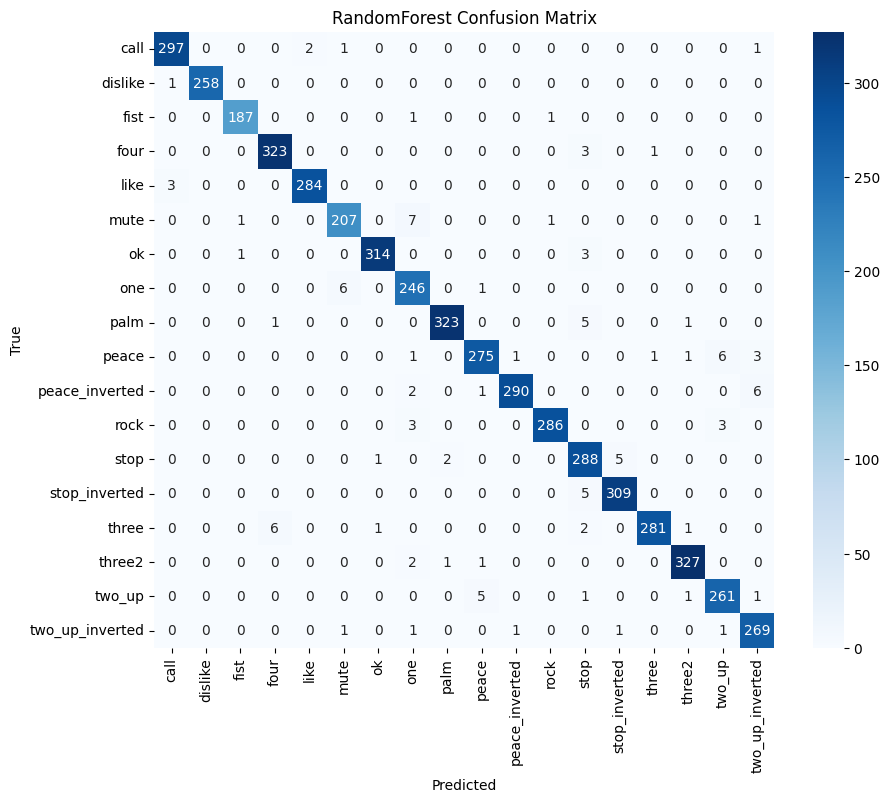

RandomForest metrics: {'accuracy': 0.9785783836416748, 'precision': 0.9788467583640375, 'recall': 0.9785783836416748, 'f1_score': 0.9786364127622691}

Evaluating SVM...


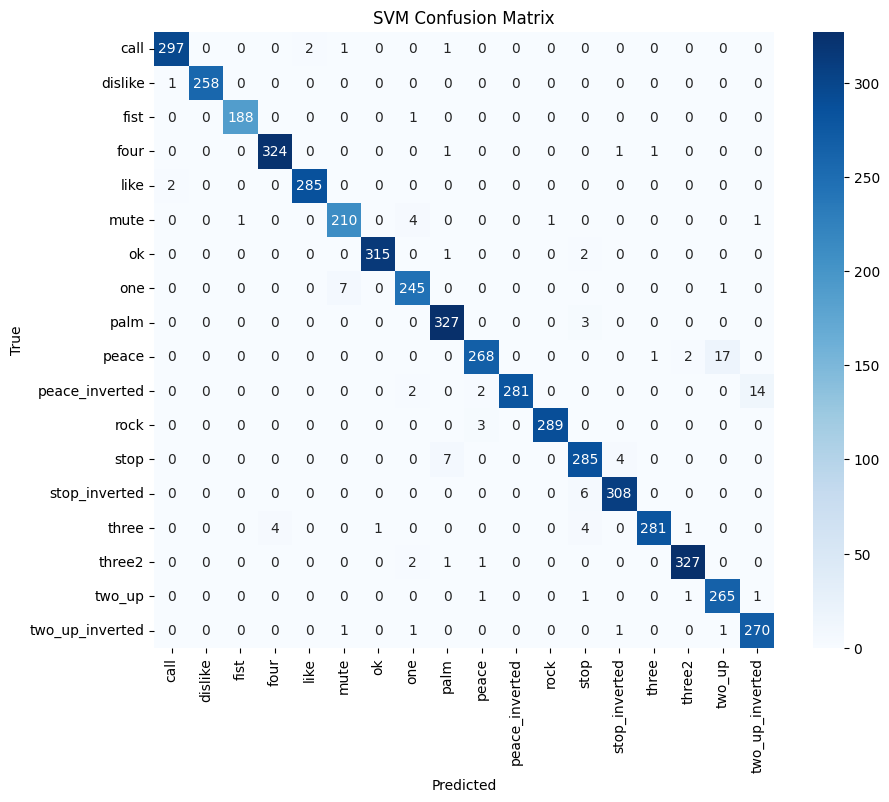

SVM metrics: {'accuracy': 0.978188899707887, 'precision': 0.9785712038899441, 'recall': 0.978188899707887, 'f1_score': 0.978209535036001}

Evaluating LogisticRegression...


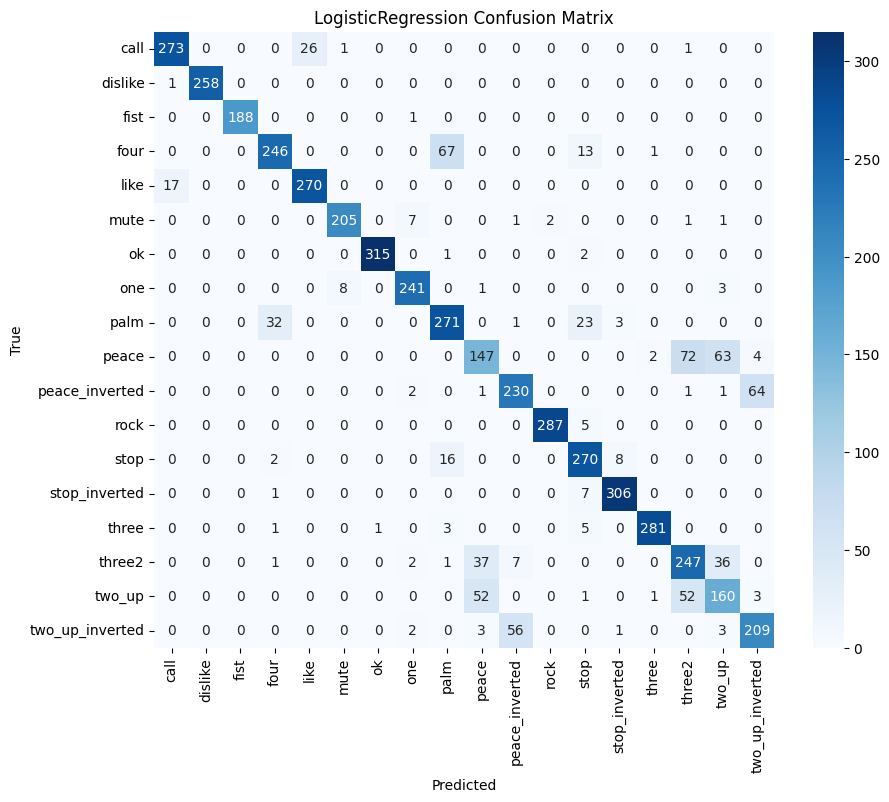

LogisticRegression metrics: {'accuracy': 0.8576436222005842, 'precision': 0.8581914021000047, 'recall': 0.8576436222005842, 'f1_score': 0.8569772337621292}



In [3]:
import sys
sys.path.append("./src")
from evaluation import evaluate_models
labels = sorted(y_test.unique())
results = evaluate_models(models, X_test, y_test, labels)